In [11]:
# Install the Kaggle library
!pip install kaggle

# Upload your kaggle.json file
# You will be prompted to choose the file after running this cell
from google.colab import files
files.upload()

# Make a directory for Kaggle and move the token there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions (important for security)
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
# Replace 'lampubhutia/nyc-flight-delay' with the correct dataset slug if different
# The slug is found in the URL of the dataset page on Kaggle:
# https://www.kaggle.com/datasets/lampubhutia/nyc-flight-delay -> lampubhutia/nyc-flight-delay
!kaggle datasets download -d lampubhutia/nyc-flight-delay

# Unzip the dataset
# Check the downloaded file name, it's usually the dataset slug name
!unzip nyc-flight-delay.zip

# List the files to see what was extracted (optional)
!ls
!ls nyc-flight-delay # The files are usually in a folder named after the dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lampubhutia/nyc-flight-delay
License(s): unknown
Archive:  nyc-flight-delay.zip
  inflating: flight_data.csv         
dictionary.html					     flights_sample_3m.csv
flight_data.csv					     nyc-flight-delay.zip
flight-delay-and-cancellation-dataset-2019-2023.zip  sample_data
ls: cannot access 'nyc-flight-delay': No such file or directory


In [18]:
# Create a new directory to unzip the files into
!mkdir -p /content/unzipped_data

# Unzip the dataset into the new directory
!unzip /content/nyc-flight-delay.zip -d /content/unzipped_data/

# List the contents of the new directory to confirm extraction
!ls -R /content/unzipped_data/

Archive:  /content/nyc-flight-delay.zip
  inflating: /content/unzipped_data/flight_data.csv  
/content/unzipped_data/:
flight_data.csv


In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# Define the path where the file was unzipped
# Based on our previous steps, this is likely /content/unzipped_data/
# Or it might be just /content/ if you didn't use the -d flag explicitly last time
# Let's assume /content/unzipped_data/ for now, but check if needed
data_path = '/content/unzipped_data/'

try:
    # ONLY load flight_data.csv as confirmed by unzip -l
    df = pd.read_csv(data_path + 'flight_data.csv')
    print("flight_data.csv loaded successfully.")

    # Let's immediately inspect the loaded dataframe to see its columns
    print("\nFirst 5 rows of the dataframe:")
    print(df.head())
    print("\nInfo of the dataframe:")
    df.info()
    print("\nColumns in the dataframe:")
    print(df.columns)

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print(f"Please ensure '{data_path}flight_data.csv' exists after unzipping.")

flight_data.csv loaded successfully.

First 5 rows of the dataframe:
   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1    1     517.0             515        2.0     830.0   
1  2013      1    1     533.0             529        4.0     850.0   
2  2013      1    1     542.0             540        2.0     923.0   
3  2013      1    1     544.0             545       -1.0    1004.0   
4  2013      1    1     554.0             600       -6.0     812.0   

   sched_arr_time  arr_delay carrier  flight tailnum origin dest  air_time  \
0             819       11.0      UA    1545  N14228    EWR  IAH     227.0   
1             830       20.0      UA    1714  N24211    LGA  IAH     227.0   
2             850       33.0      AA    1141  N619AA    JFK  MIA     160.0   
3            1022      -18.0      B6     725  N804JB    JFK  BQN     183.0   
4             837      -25.0      DL     461  N668DN    LGA  ATL     116.0   

   distance  hour  minute      time_hour 


First 5 rows of df:
   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1    1     517.0             515        2.0     830.0   
1  2013      1    1     533.0             529        4.0     850.0   
2  2013      1    1     542.0             540        2.0     923.0   
3  2013      1    1     544.0             545       -1.0    1004.0   
4  2013      1    1     554.0             600       -6.0     812.0   

   sched_arr_time  arr_delay carrier  flight tailnum origin dest  air_time  \
0             819       11.0      UA    1545  N14228    EWR  IAH     227.0   
1             830       20.0      UA    1714  N24211    LGA  IAH     227.0   
2             850       33.0      AA    1141  N619AA    JFK  MIA     160.0   
3            1022      -18.0      B6     725  N804JB    JFK  BQN     183.0   
4             837      -25.0      DL     461  N668DN    LGA  ATL     116.0   

   distance  hour  minute      time_hour  
0      1400     5      15  1/1/2013 5:00  
1  

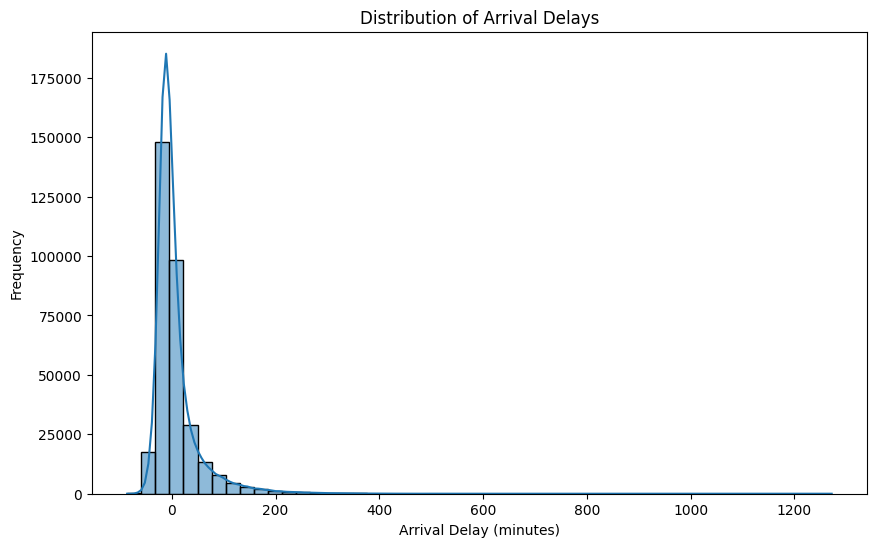


Distribution of the target variable 'is_delayed':
is_delayed
0    259146
1     77630
Name: count, dtype: int64
is_delayed
0    76.94907
1    23.05093
Name: proportion, dtype: float64


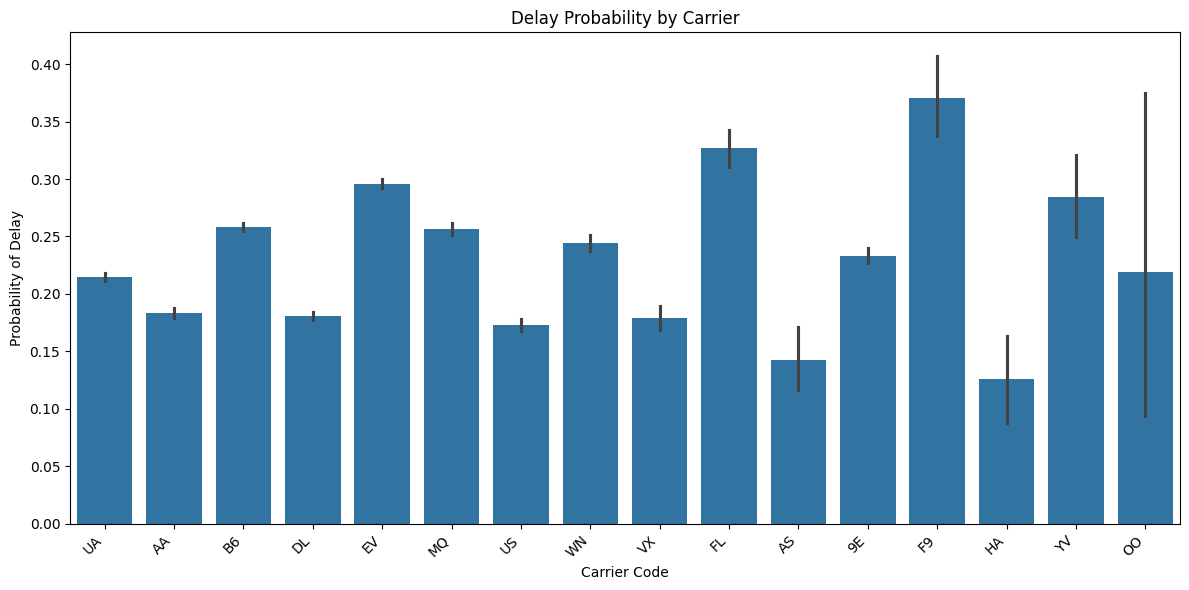

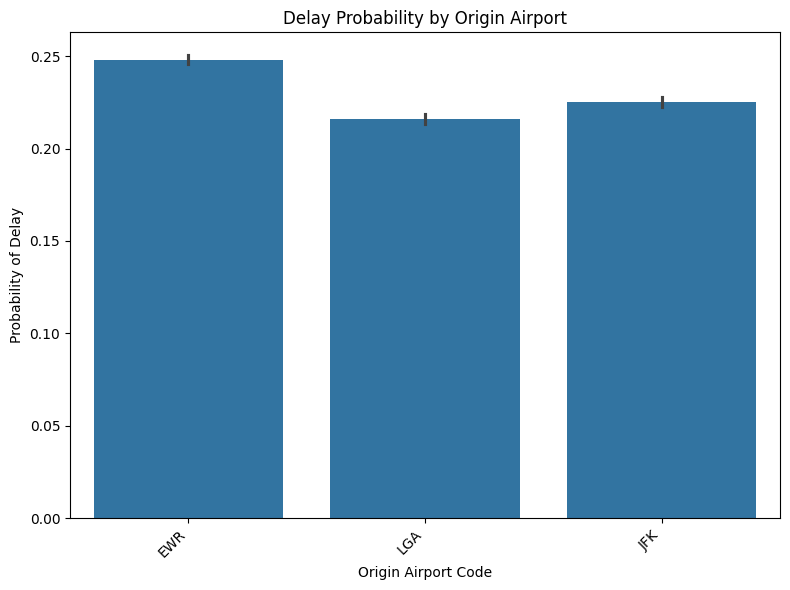

In [22]:
# Display the first few rows (already done above, but good to keep)
print("\nFirst 5 rows of df:")
print(df.head())

# Get information about the columns and data types (already done above)
print("\nInfo of df:")
df.info()

# Get basic statistical summary
print("\nDescription of df:")
print(df.describe())

# Check for missing values (already done above)
print("\nMissing values in df:")
print(df.isnull().sum())

# Analyze the distribution of the target variable (arrival delay)
plt.figure(figsize=(10, 6))
sns.histplot(df['arr_delay'].dropna(), bins=50, kde=True)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

# Define the target variable: 1 if delayed (arr_delay > 15), 0 otherwise
# Make sure to do this AFTER loading the data and before splitting
df['is_delayed'] = (df['arr_delay'] > 15).astype(int)

# Check the distribution of the target variable
print("\nDistribution of the target variable 'is_delayed':")
print(df['is_delayed'].value_counts())
print(df['is_delayed'].value_counts(normalize=True) * 100)

# Explore relationships between features and delay (example: carrier vs. delay)
# We don't have the separate airlines_df loaded, so use the 'carrier' code directly
plt.figure(figsize=(12, 6))
sns.barplot(x='carrier', y='is_delayed', data=df)
plt.title('Delay Probability by Carrier')
plt.xlabel('Carrier Code')
plt.ylabel('Probability of Delay')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Explore relationships between features and delay (example: origin airport vs. delay)
# We don't have the separate airports_df loaded, so use the 'origin' code directly
plt.figure(figsize=(8, 6))
sns.barplot(x='origin', y='is_delayed', data=df)
plt.title('Delay Probability by Origin Airport')
plt.xlabel('Origin Airport Code')
plt.ylabel('Probability of Delay')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# You can add more EDA plots here based on other columns like month, day of week, hour, distance, etc.

In [23]:
# --- Handling Missing Values ---

# For simplicity, let's drop rows where the target variable (arr_delay) is missing
# or where key time/delay info is missing
df.dropna(subset=['arr_delay', 'dep_delay', 'dep_time', 'arr_time', 'air_time'], inplace=True)

# For 'tailnum', let's drop it as it has missing values and requires external data not available
df.drop('tailnum', axis=1, inplace=True)

print(f"\nShape of data after handling missing values: {df.shape}")
print("\nMissing values after handling:")
print(df.isnull().sum())


# --- Feature Engineering ---

# Extract useful information from date and time (already have hour and minute, but let's create day_of_week and day_of_year)
# Ensure 'year', 'month', 'day' are integers before creating datetime objects
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

df['day_of_week'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofweek # Monday=0, Sunday=6
df['day_of_year'] = pd.to_datetime(df[['year', 'month', 'day']]).dt.dayofyear

# Create scheduled departure and arrival minute of day
df['sched_dep_minute_of_day'] = (df['sched_dep_time'] // 100) * 60 + (df['sched_dep_time'] % 100)
df['sched_arr_minute_of_day'] = (df['sched_arr_time'] // 100) * 60 + (df['sched_arr_time'] % 100)

# Calculate scheduled duration (handle overnight flights)
df['sched_duration'] = df['sched_arr_minute_of_day'] - df['sched_dep_minute_of_day']
# Add 24 hours (1440 minutes) if arrival is on the next day (assuming duration is within 24h)
df.loc[df['sched_duration'] < 0, 'sched_duration'] += 24 * 60

# We already have 'hour' and 'minute' from the dataset, derived from sched_dep_time

# --- Merging with Other DataFrames (SKIP as not available in this zip) ---
# The code for merging airlines, airports, planes, weather should be removed or commented out here.


# --- Feature Selection ---
# Select features to use for training. Avoid features directly related to the outcome
# like arr_delay, dep_delay, arr_time, dep_time, air_time.
# Use columns available in the loaded df.
features = [
    'year', 'month', 'day', 'day_of_week', 'day_of_year',
    'hour', 'minute', 'sched_dep_minute_of_day', 'sched_arr_minute_of_day', 'sched_duration',
    'carrier', 'flight', 'origin', 'dest',
    'distance',
    # Removed features from separate dataframes (carrier_name, airport names/lat/lon)
    # 'time_hour' is a datetime string, let's use the engineered numerical date/time features instead
]

# Drop columns that are not features or the target variable 'is_delayed'
# Keep only the selected features and the target variable
features_and_target = features + ['is_delayed']
df_filtered = df[features_and_target].copy()

# Note: We handled missing values earlier, so there should be no missing values
# in the selected features and target after dropping rows.

# --- Separate Target Variable ---
X = df_filtered.drop('is_delayed', axis=1)
y = df_filtered['is_delayed']

# --- Identify Categorical and Numerical Features for Preprocessing ---
# Update based on the features list we just defined
categorical_features = [
    'year', 'month', 'day', 'day_of_week',
    'carrier', 'origin', 'dest',
    # Removed categorical features from separate dataframes
]
numerical_features = [
    'hour', 'minute', 'sched_dep_minute_of_day', 'sched_arr_minute_of_day', 'sched_duration',
    'flight', 'distance',
    # Removed numerical features from separate dataframes (lat/lon)
]

# Ensure all identified features exist in X
categorical_features = [col for col in categorical_features if col in X.columns]
numerical_features = [col for col in numerical_features if col in X.columns]


# --- Create Preprocessing Pipelines for Numerical and Categorical Features ---
# This part remains the same, but uses the updated categorical and numerical feature lists
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # handle_unknown='ignore' is useful if test set has new categories

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) - not relevant here after selection
)


# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain delay distribution

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of data after handling missing values: (327346, 19)

Missing values after handling:
year              0
month             0
day               0
dep_time          0
sched_dep_time    0
dep_delay         0
arr_time          0
sched_arr_time    0
arr_delay         0
carrier           0
flight            0
origin            0
dest              0
air_time          0
distance          0
hour              0
minute            0
time_hour         0
is_delayed        0
dtype: int64

Shape of X_train: (261876, 15)
Shape of X_test: (65470, 15)
Shape of y_train: (261876,)
Shape of y_test: (65470,)



Training Logistic Regression Model...
Logistic Regression Model Training Complete.

Training Random Forest Classifier Model...
Random Forest Classifier Model Training Complete.

Training Gradient Boosting Classifier Model...
Gradient Boosting Classifier Model Training Complete.

--- Evaluation for Logistic Regression ---
Accuracy: 0.7696
Precision: 0.5728
Recall: 0.1119
F1-Score: 0.1873
ROC-AUC Score: 0.7030
Confusion Matrix:
[[48648  1296]
 [13788  1738]]


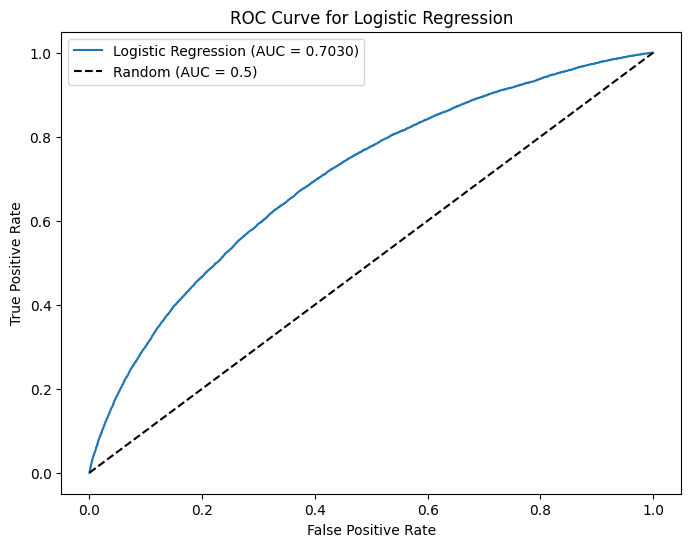


--- Evaluation for Random Forest Classifier ---
Accuracy: 0.8156
Precision: 0.7293
Recall: 0.3540
F1-Score: 0.4766
ROC-AUC Score: 0.7950
Confusion Matrix:
[[47904  2040]
 [10030  5496]]


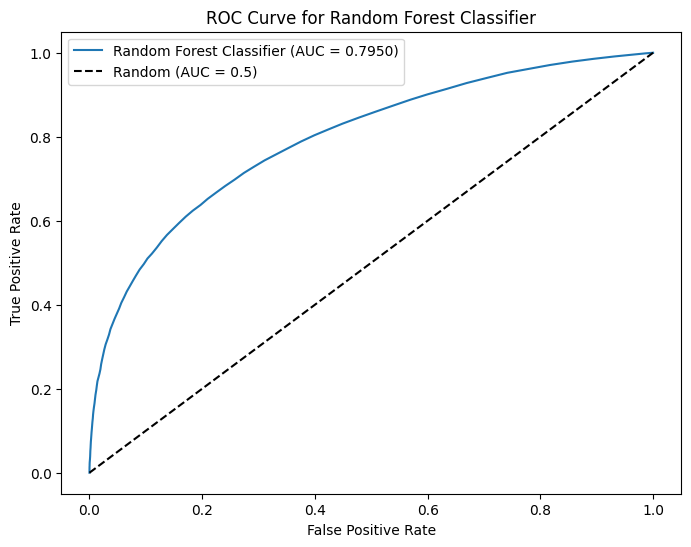


--- Evaluation for Gradient Boosting Classifier ---
Accuracy: 0.7800
Precision: 0.7389
Recall: 0.1117
F1-Score: 0.1941
ROC-AUC Score: 0.7378
Confusion Matrix:
[[49331   613]
 [13791  1735]]


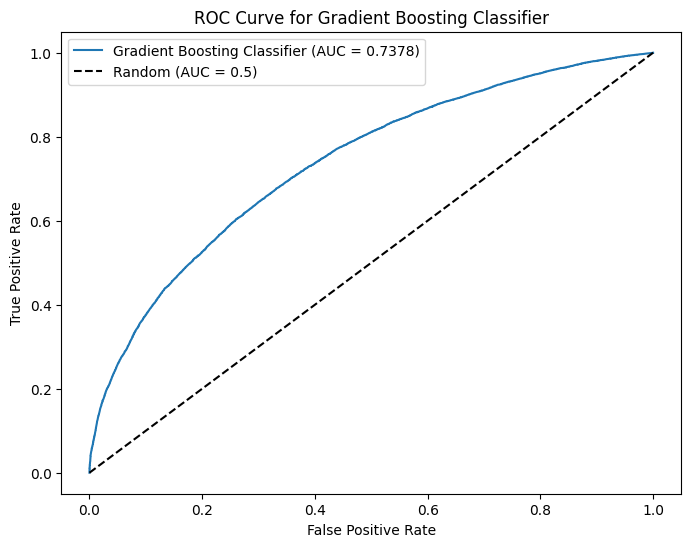

In [24]:
# --- Create and Train Models within Pipelines ---

# Pipeline for Logistic Regression
# Using a smaller number of estimators for demonstration; tune for better performance
# solver='liblinear' is good for smaller datasets or when using L1 regularization
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

print("\nTraining Logistic Regression Model...")
log_reg_pipeline.fit(X_train, y_train)
print("Logistic Regression Model Training Complete.")

# Pipeline for Random Forest Classifier
# Using a smaller number of estimators for demonstration; tune for better performance
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

print("\nTraining Random Forest Classifier Model...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest Classifier Model Training Complete.")

# Pipeline for Gradient Boosting Classifier
# Using a smaller number of estimators for demonstration; tune for better performance
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))])

print("\nTraining Gradient Boosting Classifier Model...")
gb_pipeline.fit(X_train, y_train)
print("Gradient Boosting Classifier Model Training Complete.")


# --- Model Evaluation ---

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates the model and prints key metrics."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n--- Evaluation for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)') # Corrected label for random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.show()


# Evaluate the trained models
evaluate_model(log_reg_pipeline, X_test, y_test, "Logistic Regression")
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest Classifier")
evaluate_model(gb_pipeline, X_test, y_test, "Gradient Boosting Classifier")

In [25]:
# --- Make Predictions on New Data ---
# Assume 'new_flight_data' is a pandas DataFrame with the same columns as X (features)
# before preprocessing. The columns MUST match the 'features' list used in preprocessing.

# Example of creating dummy new data (replace with your actual new data)
# Make sure the columns and data types match the training data
new_flight_data = pd.DataFrame({
    'year': [2013],
    'month': [1],
    'day': [1],
    'day_of_week': [1], # Monday
    'day_of_year': [1],
    'hour': [6],
    'minute': [0],
    'sched_dep_minute_of_day': [360], # 6 * 60 + 0
    'sched_arr_minute_of_day': [540], # Example: 9:00 AM
    'sched_duration': [180], # 540 - 360 = 180 minutes
    'carrier': ['UA'], # Example Carrier
    'flight': [123], # Example Flight Number
    'origin': ['EWR'], # Example Origin Airport
    'dest': ['LAX'], # Example Destination Airport
    'distance': [2454], # Example Distance in miles
})

# Use the trained pipeline to make predictions
# Choose the best performing model based on your evaluation metrics from Step 4
best_model = rf_pipeline # Example: using Random Forest, but choose based on evaluation

print("\nMaking predictions on new data...")
# The pipeline handles the preprocessing of new_flight_data automatically
new_prediction = best_model.predict(new_flight_data)
new_prediction_proba = best_model.predict_proba(new_flight_data)[:, 1] # Probability of the positive class (delayed)

print(f"\nPrediction for the new flight: {'Delayed' if new_prediction[0] == 1 else 'On-time'}")
print(f"Probability of delay: {new_prediction_proba[0]:.4f}")


Making predictions on new data...

Prediction for the new flight: On-time
Probability of delay: 0.1700


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
import joblib
model_filename = 'flight_delay_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as flight_delay_model.pkl
